# In this challenge, machine learning will be used for recommender systems: applications that learn, from historical data, how to suggest the best items for customers in order to maximize some business metric, such as billing, conversion rate, among others.

## For this challenge is that you create a recommendation system from [MovieLens](https://caelum57945.lt.acemlnb.com/Prod/link-tracker?redirectUrl=aHR0cHMlM0ElMkYlMkZncm91cGxlbnMub3JnJTJGZGF0YXNldHMlMkZtb3ZpZWxlbnMlMkYxMDBrJTJGJTNGdXRtX3NvdXJjZSUzREFjdGl2ZUNhbXBhaWduJTI2dXRtX21lZGl1bSUzRGVtYWlsJTI2dXRtX2NvbnRlbnQlM0QlMjUyMzdEYXlzT2ZDb2RlJTJCLSUyQkNpJTI1QzMlMjVBQW5jaWElMkJkZSUyQkRhZG9zJTJCNCUyNTJGNyUyNTNBJTJCJTI1RjAlMjU5RiUyNTkxJTI1QTklMjVGMCUyNTlGJTI1OEYlMjVCRCUyNUUyJTI1ODAlMjU4RCUyNUYwJTI1OUYlMjU5MiUyNUJCJTJCU2lzdGVtYXMlMkJkZSUyQnJlY29tZW5kYSUyNUMzJTI1QTclMjVDMyUyNUEzbyUyNnV0bV9jYW1wYWlnbiUzRCUyNTVCQWx1cmElMkIlMjUyMzdEYXlzJTJCT2YlMkJDb2RlJTI1NUQlMjUyOEphdmElMjUyOSUyQkRpYSUyQjQlMjUyRjclMjUzQSUyQkdlcmFuZG8lMkJvJTJCSFRNTA==&sig=7j4XsTVPi162Ej2E9t7K4zaFUTtvNuQbKz1Cs8dszyzA&iat=1650884647&a=%7C%7C476258007%7C%7C&account=caelum57945%2Eactivehosted%2Ecom&email=QqijRIKiWAFuIspL1ED2f44JfrMRa%2BBFjz0CY4L4uKs%3D&s=5a70e54c4217d2fff46f3475ff1a44b5&i=1376A8451A266A9325).

# Load libraries

In [156]:
import numpy as np
import pandas as pd
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

from joblib import dump

import warnings
warnings.filterwarnings('ignore')

# [Load data](http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/)

## Load data users

In [2]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('dataset/ml-100k/u.user', sep='|',
                    names=u_cols, encoding='latin-1')
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


## Load data ratings

In [3]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('dataset/ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


## Load movies data

In [4]:
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('dataset/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5), encoding='latin-1')
movies

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


## Create a merged dataset

In [5]:
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)
lens

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,748,"Saint, The (1997)",14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Saint%2C%20Th...,729,4,893286638,19,M,student,56567
99996,751,Tomorrow Never Dies (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,729,3,893286338,19,M,student,56567
99997,879,"Peacemaker, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Peacemaker%2C...,729,3,893286299,19,M,student,56567
99998,894,Home Alone 3 (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,729,1,893286511,19,M,student,56567


# Getting some information about the dataset

## What are the 25 most rated movies?

In [6]:
most_rated = lens.groupby('title').size().sort_values(ascending=False)[:25]
most_rated

title
Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Titanic (1997)

## Describe

In [7]:
ratings.describe()

,user_id,movie_id,rating,unix_timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


## Rating that were most used

<AxesSubplot:xlabel='x'>

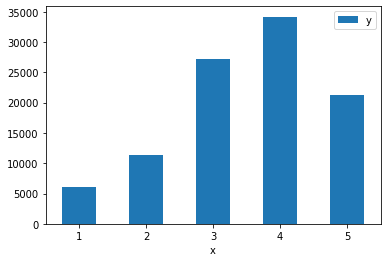

In [30]:
df_plot = pd.DataFrame(
    {
        'x': ratings['rating'].sort_values().unique(),
        'y': ratings['rating'].value_counts().sort_index()
    }
)
df_plot.plot.bar(x='x', y='y', rot=0)

## Some more statistics

In [46]:
print(f'Total number of Ratings: {ratings["rating"].count()}')
print(f'Total number of Users: {len(ratings["user_id"].value_counts().index)}')
print(f'Avarage Number of Ratings by User: {ratings["rating"].count()/len(ratings["user_id"].value_counts().index)}')

Total number of Ratings: 100000
Total number of Users: 943
Avarage Number of Ratings by User: 106.04453870625663


# [Popularity-based recommendation](https://medium.com/data-hackers/criando-sistemas-de-recomenda%C3%A7%C3%A3o-em-python-ef350f601e3d)

## Movies with more than 50 ratings

In [47]:
new_df = ratings.groupby('movie_id').filter(lambda x: x['rating'].count() >= 50)
new_df

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
...,...,...,...,...
99993,913,209,2,881367150
99995,880,476,3,880175444
99996,716,204,5,879795543
99998,13,225,2,882399156


## New DataFrame with average rating and number of ratings per movie

In [49]:
ratings_df = pd.DataFrame(new_df.groupby('movie_id').rating.mean())
ratings_df

,rating
movie_id,
1,3.878319
2,3.206107
3,3.033333
4,3.550239
5,3.302326
...,...
1065,3.490566
1073,3.818182
1074,2.961039


## Adding column with number of reviews per movie

In [50]:
ratings_df['rating_counts'] = new_df.groupby('movie_id').rating.count()
ratings_df

,rating,rating_counts
movie_id,,
1,3.878319,452
2,3.206107,131
3,3.033333,90
4,3.550239,209
5,3.302326,86
...,...,...
1065,3.490566,53
1073,3.818182,66
1074,2.961039,77


## View of the 5 best rated films (number of ratings)

In [51]:
ratings_df.sort_values(by='rating_counts', ascending=False).head(5)

,rating,rating_counts
movie_id,,
50,4.358491,583
258,3.803536,509
100,4.155512,508
181,4.007890,507
294,3.156701,485


## Global Average of Ratings

In [52]:
C = ratings_df['rating'].mean()
C

3.528579825884183

## Minimum threshold to be eligible for the ranking

In [53]:
m = ratings_df.rating_counts.min()
m

50

## Function that calculates the weighted average of each item

In [54]:
def weighted_rating (x, m = m, C = C):
    v = x['rating_counts']
    R = x['rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

## Add the 'score' calculated with weighted rating() to the dataframe

In [55]:
ratings_df['score'] = ratings_df.apply(weighted_rating, axis=1)
ratings_df

,rating,rating_counts,score
movie_id,,,
1,3.878319,452,3.843484
2,3.206107,131,3.295188
3,3.033333,90,3.210207
4,3.550239,209,3.546058
5,3.302326,86,3.385507
...,...,...,...
1065,3.490566,53,3.509019
1073,3.818182,66,3.693353
1074,2.961039,77,3.184480


## Final result with the 15 most popular movies

In [56]:
ratings_df.sort_values(by='score', ascending=False).head(15)

,rating,rating_counts,score
movie_id,,,
318,4.466443,298,4.331693
64,4.445230,283,4.307595
483,4.456790,243,4.298392
50,4.358491,583,4.292937
12,4.385768,267,4.250565
603,4.387560,209,4.221734
98,4.289744,390,4.203248
127,4.283293,413,4.201790
408,4.491071,112,4.194006


# [Collaborative filtering (item-item recommendation)](https://medium.com/data-hackers/criando-sistemas-de-recomenda%C3%A7%C3%A3o-em-python-ef350f601e3d)

## Reading dataset

In [78]:
new_df

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
...,...,...,...,...
99993,913,209,2,881367150
99995,880,476,3,880175444
99996,716,204,5,879795543
99998,13,225,2,882399156


In [65]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df.drop('unix_timestamp', axis=1), reader)
data

## Split data

In [69]:
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

## Creating an item-based model (user_based true / false to switch between user-based or item-based collaborative filtering)

In [70]:
algo = KNNWithMeans(k=5, sim_options={'user_based': False})
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


## Sabe model

In [157]:
dump(algo, 'surprise_prediction_algorithms_knns_KNNWithMeans.sav')

['surprise_prediction_algorithms_knns_KNNWithMeans.sav']

## Test model

In [73]:
test_pred = algo.test(testset)

## Result

In [74]:
print('Item-based Model : Test Set')
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.9731


0.9731304938258023

## Using get_neighbors function to get the 10 recommendations for the movie at index 1

In [75]:
algo.get_neighbors(1, 10)

[546, 117, 306, 430, 239, 462, 508, 522, 554, 579]

In [102]:
filter_list = new_df.iloc[[546, 117, 306, 430, 239, 462, 508, 522, 554, 579]].movie_id
movies.query(f'movie_id == {filter_list.values.tolist()}')

,movie_id,title,release_date,video_release_date,imdb_url
12,13,Mighty Aphrodite (1995),30-Oct-1995,NaN,http://us.imdb.com/M/title-exact?Mighty%20Aphr...
170,171,Delicatessen (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Delicatessen%...
216,217,Bram Stoker's Dracula (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Bram%20Stoker...
228,229,Star Trek III: The Search for Spock (1984),01-Jan-1984,NaN,http://us.imdb.com/M/title-exact?Star%20Trek%2...
270,271,Starship Troopers (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Starship+Troo...
345,346,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...
496,497,Bringing Up Baby (1938),01-Jan-1938,NaN,http://us.imdb.com/M/title-exact?Bringing%20Up...
657,658,Pump Up the Volume (1990),01-Jan-1990,NaN,http://us.imdb.com/M/title-exact?Pump%20Up%20t...
812,813,"Celluloid Closet, The (1995)",15-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Celluloid%20C...
1027,1028,Grumpier Old Men (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Grumpier%20Ol...


# Matrix Factoring System (SVD Algorithm)

## Let's work with 50 thousand rows due to computational use

In [105]:
new_df1 = new_df.head(50000)
ratings_matrix = new_df1.pivot_table(values='rating', index='user_id', columns='movie_id', fill_value=0)
ratings_matrix.head()

movie_id,1,2,3,4,5,7,8,9,10,11,...,1035,1039,1041,1047,1048,1065,1073,1074,1101,1119
user_id,,,,,,,,,,,,,,,,,,,,,
1,5,3,0,0,3,0,1,5,3,2,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
ratings_matrix.shape

(870, 603)

## Matrix transpose

In [106]:
X = ratings_matrix.T
X.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,864,865,866,867,868,870,871,872,875,876
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5,4,0,0,4,4,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,5,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
X.shape

(603, 870)

## Matrix Decomposition. The Truncated SVD function will actually reduce the dimension of the sparse matrix into the number of components requested

In [107]:
SVD_model = TruncatedSVD(n_components=10)
decomposed_matrix = SVD_model.fit_transform(X)
decomposed_matrix.shape

(603, 10)

## Save model

In [160]:
dump(decomposed_matrix, 'TruncatedSVC_SVD_model.sav')

['TruncatedSVC_SVD_model.sav']

## Correlation matrix

In [110]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(603, 603)

In [151]:
i = 2

movie_names = list(X.index)
movie_ID = movie_names.index(i)
movie_ID

1

## Correlation for all items with the item rated by this customer, based on items rated by others from customers who have rated the same product

In [152]:
correlation_movie_ID = correlation_matrix[movie_ID]
correlation_movie_ID.shape

(603,)

In [153]:
Recommend = list(X.index[correlation_movie_ID > 0.65])
Recommend.remove(i)
Recommend[0:10]

[3, 4, 5, 7, 8, 11, 12, 17, 21, 22]

In [154]:
movies.query(f'movie_id == {[3, 4, 5, 7, 8, 11, 12, 17, 21, 22]}')

,movie_id,title,release_date,video_release_date,imdb_url
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
6,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...
7,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995)
10,11,Seven (Se7en) (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Se7en%20(1995)
11,12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...
16,17,From Dusk Till Dawn (1996),05-Feb-1996,NaN,http://us.imdb.com/M/title-exact?From%20Dusk%2...
20,21,Muppet Treasure Island (1996),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Muppet%20Trea...
21,22,Braveheart (1995),16-Feb-1996,NaN,http://us.imdb.com/M/title-exact?Braveheart%20...
